In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def read_junc(junc_file, ):
    junc = pd.read_csv(junc_file, sep='\t', 
                  names = ['chrom', 'start', 'end', 'junction_id', 'read', 'strand', 
                           'annot', 'ensembl', 'gene_id', 'SuperAnnotation', 'SemiSupergroupAnnotations'])
    
    junc['isNMD'] = np.array(junc.SuperAnnotation.str.contains('_UnproductiveCodingGene'))
    #junc['isNMD'] = np.array(junc.annot == 'processed_transcript.gencode')
    junc['isProteinCoding'] = np.array(junc.SuperAnnotation.str.contains('_ProductiveCodingGene'))
    junc['count_exons'] = [1]*len(junc)
    
    return junc

def get_counts_and_NMD_reads(junc, juncs_to_remove, max_junc):
    
    remove_junc = np.array(junc.junction_id.isin(juncs_to_remove))
    junc['remove_junc'] = remove_junc
    reads_to_remove = junc.groupby('read').remove_junc.any().loc[
        junc.groupby('read').remove_junc.any()
    ].index
    
#     pc_reads = pd.Index(junc.read.unique())
    
    pc_reads = junc.groupby('read').isProteinCoding.any().loc[
        junc.groupby('read').isProteinCoding.any()
    ].index
    
    junctions_per_read = junc.loc[
        junc.read.isin(pc_reads) & (~junc.read.isin(reads_to_remove))
    ].groupby('read').count_exons.sum()
    
    NMD_junctions_in_read = junc.loc[
        junc.read.isin(pc_reads) & (~junc.read.isin(reads_to_remove))
    ].groupby('read').isNMD.any()

    NMD_reads = [NMD_junctions_in_read.loc[
        junctions_per_read.loc[junctions_per_read == i].index
    ].mean() for i in range(1, max_junc)]
    
    
#     pc_reads_id = pd.Index(junc.read.unique())
    pc_reads_id = junc.groupby('read').isProteinCoding.any().loc[
        junc.groupby('read').isProteinCoding.any()
    ].index


    NMD_reads_id = junc.groupby('read').isNMD.any().loc[
        junc.groupby('read').isNMD.any()
    ].index
    
    
    junc['isProteinCoding_read'] = junc.read.isin(pc_reads_id)
    junc['isNMD_read'] = junc.read.isin(pc_reads_id.intersection(NMD_reads_id))
    
    pc_reads_out = pc_reads.difference(reads_to_remove)
    
    return junc, NMD_reads, junctions_per_read, pc_reads_out

def wrap_junc(junc_file, juncs_to_remove = ['chr17:81510329-81510479:-'], max_junc = 15, subset_genes=None):
    junc = read_junc(junc_file, )
    if subset_genes:
        junc = junc.loc[junc.ensembl.isin(subset_genes)]
    junc, NMD_reads, x, y = get_counts_and_NMD_reads(junc, juncs_to_remove, max_junc)
    return junc, NMD_reads

intron_annot = pd.read_csv('../data/IntronAnnotationsFromYang.tsv.gz', sep='\t')

nmd_list = ['nonsense_mediated_decay.pstopcodon',
 'nonsense_mediated_decay.gencode',
 'nonsense_mediated_decay.YN',
 'nonsense_mediated_decay.far5p',
 'nonsense_mediated_decay.far3p',
 'nonsense_mediated_decay.reason2',
 'nonsense_mediated_decay.novel_junctions',
 'nonsense_mediated_decay.reason1',
 'retained_intron.gencode',
 'retained_intron.novel_junctions',
 'processed_transcript.gencode',
 'processed_transcript.novel_junctions']

juncs_to_remove = ['chr17:81510329-81510479:-',]

nuclear_junc = []
nuclear_NMD_reads = []
total_junc = []
total_NMD_reads = []
for i in ((np.array(range(5)) * 2) + 1):
    n_junc, n_NMD_reads, = wrap_junc('../code/LongReads/Junctions/GM{i}.annotated.junc.gz'.format(i=str(i)), 
                                    juncs_to_remove = juncs_to_remove)
    t_junc, t_NMD_reads, = wrap_junc('../code/LongReads/Junctions/GM{i}.annotated.junc.gz'.format(i=str(i+1)), 
                                    juncs_to_remove = juncs_to_remove)
    
    nuclear_junc.append(n_junc)
    nuclear_NMD_reads.append(n_NMD_reads)
    
    total_junc.append(t_junc)
    total_NMD_reads.append(t_NMD_reads)
    


In [2]:
# PC_reads = n_junc.loc[n_junc.SuperAnnotation.isin(['AnnotatedJunc_ProductiveCodingGene',
#                              'UnnnotatedJunc_ProductiveCodingGene',
#                                                   'AnnotatedJunc_UnproductiveCodingGene',
#                              'UnnnotatedJunc_UnproductiveCodingGene'])].read.unique()

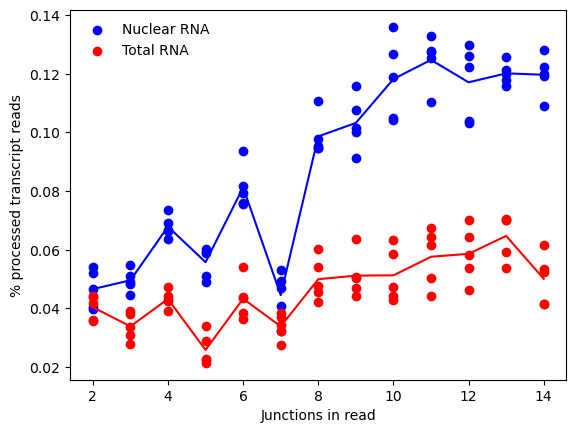

In [3]:
for i in range(len(nuclear_NMD_reads)):
    l = nuclear_NMD_reads[i]
    if i == 0:
        plt.scatter(np.arange(1, len(l))+1, l[1:], c='blue', label='Nuclear RNA')
    else:
        plt.scatter(np.arange(1, len(l))+1, l[1:], c='blue')
        
mean_ = [np.mean((np.array(nuclear_NMD_reads).T)[i]) for i in range(1, len(l))]
plt.plot(np.arange(1, len(l))+1, mean_, c='blue')
        

    
for i in range(len(total_NMD_reads)):
    l = total_NMD_reads[i]
    if i == 0:
        plt.scatter(np.arange(1, len(l))+1, l[1:], c='red', label='Total RNA')
    else:
        plt.scatter(np.arange(1, len(l))+1, l[1:], c='red')
        
mean_ = [np.mean((np.array(total_NMD_reads).T)[i]) for i in range(1, len(l))]
plt.plot(np.arange(1, len(l))+1, mean_, c='red')
    
plt.xlabel('Junctions in read')
plt.ylabel('% processed transcript reads')



plt.legend(frameon=False)

In [4]:
def select_random_read(GM, GM_junc_per_read, n):
    GM_df = GM.loc[GM.read == np.random.choice(GM_junc_per_read.loc[GM_junc_per_read == n].index)]
    return GM_df

def subsample_junctions(GM_df, k):
    junc_subset = np.random.choice(np.array(GM_df.annot), k, replace=False)
    return junc_subset

def subsample_is_nmd(GM, GM_junc_per_read, n, k):
    nmd_list = [x for x in GM.annot.unique() if '_UnproductiveCodingGene' in x]
    GM_df = select_random_read(GM, GM_junc_per_read, n)
    junc_subset = subsample_junctions(GM_df, k)
    isNMD = np.any([x in nmd_list for x in junc_subset])
    return isNMD

def select_reads_by_number_of_junctions(GM, GM_junctions_per_read, GM_pc_reads, n):
    
    GM_junctions_per_read = GM_junctions_per_read.loc[GM_pc_reads]
    GM_subsample = GM.loc[GM.read.isin(GM_junctions_per_read.loc[
        (GM_junctions_per_read >= n) & (GM_junctions_per_read <= 15)].index)]
    
    is_nmd = []
    
    for x, y in tqdm(GM_subsample.groupby('read'), position=0, leave=True):
        is_nmd.append(any(np.random.choice(y.isNMD, n, replace=False)))
        
    nmd_mean = np.mean(is_nmd)
    return nmd_mean
        

def get_NMD_avg(junc, juncs_to_remove, max_junc, i):
    
    remove_junc = np.array(junc.junction_id.isin(juncs_to_remove))
    junc['remove_junc'] = remove_junc
    reads_to_remove = junc.groupby('read').remove_junc.any().loc[
        junc.groupby('read').remove_junc.any()
    ].index
    
    pc_reads = junc.groupby('read').isProteinCoding.any().loc[
        junc.groupby('read').isProteinCoding.any()
    ].index
    
    junctions_per_read = junc.loc[
        junc.read.isin(pc_reads) & (~junc.read.isin(reads_to_remove))
    ].groupby('read').count_exons.sum()
    
    NMD_junctions_in_read = junc.loc[
        junc.read.isin(pc_reads) & (~junc.read.isin(reads_to_remove))
    ].groupby('read').isNMD.any()

    NMD_reads = [NMD_junctions_in_read.loc[
        junctions_per_read.loc[junctions_per_read == i].index
    ].mean() for i in range(1, max_junc)]
    
    
    
    pc_reads_id = junc.groupby('read').isProteinCoding.any().loc[
        junc.groupby('read').isProteinCoding.any()
    ].index


    NMD_reads_id = junc.groupby('read').isNMD.any().loc[
        junc.groupby('read').isNMD.any()
    ].index
    
    
    junc['isProteinCoding_read'] = junc.read.isin(pc_reads_id)
    junc['isNMD_read'] = junc.read.isin(pc_reads_id.intersection(NMD_reads_id))
    
    y = select_reads_by_number_of_junctions(junc, junctions_per_read, 
                                    pc_reads.difference(reads_to_remove), i)
    
#     print(y[:10])
#     mean_y = np.mean(y)
    print(y)
    return y
    
#     return junc, NMD_reads
juncs_to_remove = ['chr17:81510329-81510479:-']

def subsample_juncs(junc_file, juncs_to_remove, subset_genes=None):
    
    junc = read_junc(junc_file)
    
    if subset_genes:
        junc = junc.loc[junc.ensembl.isin(subset_genes)]
    
    
    gm_nmd_avg = []
    for i in range(1, 16):
        y = get_NMD_avg(junc, juncs_to_remove, 16, i)
        gm_nmd_avg.append(y)
    return gm_nmd_avg
    
    
from tqdm import tqdm



In [5]:
nmd_avgs = []
for i in range(1, 11):

    x = subsample_juncs('../code/LongReads/Junctions/GM{i}.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove)
    nmd_avgs.append(x)
    
nuclear_NMD_reads = np.array(nmd_avgs[::2])*100
total_NMD_reads = np.array(nmd_avgs[1::2])*100

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105830/105830 [00:12<00:00, 8562.99it/s]


0.016583199470849474


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96149/96149 [00:11<00:00, 8500.72it/s]


0.03342728473515065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84731/84731 [00:10<00:00, 8430.89it/s]


0.04306570204529629


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69628/69628 [00:08<00:00, 8506.98it/s]


0.051918768311598786


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58196/58196 [00:06<00:00, 8460.70it/s]


0.057667193621554744


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47090/47090 [00:05<00:00, 8342.90it/s]


0.06736037375238904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39018/39018 [00:04<00:00, 8448.44it/s]


0.07314572761289662


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25134/25134 [00:03<00:00, 8374.74it/s]


0.09612477122622742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18840/18840 [00:02<00:00, 8375.26it/s]


0.10679405520169852


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13635/13635 [00:01<00:00, 8296.77it/s]


0.11463146314631463


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9936/9936 [00:01<00:00, 8381.23it/s]


0.11553945249597423


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6925/6925 [00:00<00:00, 8296.74it/s]


0.11465703971119133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4506/4506 [00:00<00:00, 8348.91it/s]


0.11273857079449623


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2529/2529 [00:00<00:00, 8318.36it/s]


0.11466982997232107


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1080/1080 [00:00<00:00, 8232.17it/s]


0.1259259259259259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121729/121729 [00:14<00:00, 8499.07it/s]


0.010449440971337973


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115923/115923 [00:13<00:00, 8372.04it/s]


0.02099669608274458


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106793/106793 [00:12<00:00, 8481.43it/s]


0.027380071727547684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91745/91745 [00:10<00:00, 8466.91it/s]


0.0324159354733228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79814/79814 [00:09<00:00, 8477.11it/s]


0.03648482722329416


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63332/63332 [00:07<00:00, 8451.91it/s]


0.04315354007452789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53369/53369 [00:06<00:00, 8421.32it/s]


0.04564447525717177


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38327/38327 [00:04<00:00, 8429.43it/s]


0.05398283194614763


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29502/29502 [00:03<00:00, 8420.99it/s]


0.057623211985628094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21603/21603 [00:02<00:00, 8380.96it/s]


0.06013053742535759


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15696/15696 [00:01<00:00, 8315.90it/s]


0.0628822629969419


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11033/11033 [00:01<00:00, 8386.71it/s]


0.06380857427716849


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7527/7527 [00:00<00:00, 8346.61it/s]


0.06430184668526638


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4445/4445 [00:00<00:00, 8278.41it/s]


0.06209223847019123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1734/1734 [00:00<00:00, 8312.80it/s]


0.08131487889273356


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76383/76383 [00:08<00:00, 8504.11it/s]


0.01777882513124648


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69577/69577 [00:08<00:00, 8492.76it/s]


0.036118257470140996


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61178/61178 [00:07<00:00, 8396.68it/s]


0.04676517702442054


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51331/51331 [00:06<00:00, 8468.37it/s]


0.05719740507685414


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43297/43297 [00:05<00:00, 8500.03it/s]


0.06457722244035384


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35013/35013 [00:04<00:00, 8473.08it/s]


0.07637163339331106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29348/29348 [00:03<00:00, 8481.67it/s]


0.08109581572849939


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19569/19569 [00:02<00:00, 8279.27it/s]


0.1045531197301855


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15131/15131 [00:01<00:00, 8430.69it/s]


0.11109642455885269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11100/11100 [00:01<00:00, 8209.52it/s]


0.11747747747747747


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8144/8144 [00:00<00:00, 8372.56it/s]


0.11824656188605108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5806/5806 [00:00<00:00, 8427.21it/s]


0.12073716844643473


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3778/3778 [00:00<00:00, 8318.97it/s]


0.12652196929592377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2170/2170 [00:00<00:00, 8303.92it/s]


0.1327188940092166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 897/897 [00:00<00:00, 8308.60it/s]


0.1426978818283166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124257/124257 [00:14<00:00, 8359.69it/s]


0.009810312497485051


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118669/118669 [00:14<00:00, 8367.65it/s]


0.019600738187732263


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108875/108875 [00:12<00:00, 8471.55it/s]


0.025506314580941446


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94465/94465 [00:11<00:00, 8397.30it/s]


0.028984279892023502


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82396/82396 [00:09<00:00, 8400.48it/s]


0.03211320937909607


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64596/64596 [00:07<00:00, 8381.66it/s]


0.038051891758003595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54385/54385 [00:06<00:00, 8490.87it/s]


0.04216236094511354


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39289/39289 [00:04<00:00, 8376.88it/s]


0.048588663493598715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30761/30761 [00:03<00:00, 8326.80it/s]


0.051558791976853806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22284/22284 [00:02<00:00, 8377.24it/s]


0.0555106803087417


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16191/16191 [00:01<00:00, 8336.71it/s]


0.05762460626273856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11516/11516 [00:01<00:00, 8233.97it/s]


0.0598298020145884


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 8329.20it/s]


0.06294155427103404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4711/4711 [00:00<00:00, 8252.49it/s]


0.059647633198896204


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1759/1759 [00:00<00:00, 8293.10it/s]


0.07617964752700399


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79198/79198 [00:09<00:00, 8471.74it/s]


0.014406929467915856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72362/72362 [00:08<00:00, 8360.32it/s]


0.029476797214007353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63240/63240 [00:07<00:00, 8442.36it/s]


0.03889943074003795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52510/52510 [00:06<00:00, 8419.21it/s]


0.04909541039801942


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45062/45062 [00:05<00:00, 8231.67it/s]


0.055257201189472284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37093/37093 [00:04<00:00, 8353.03it/s]


0.06534925727226161


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31191/31191 [00:03<00:00, 8430.31it/s]


0.0691866243467667


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20675/20675 [00:02<00:00, 8330.79it/s]


0.09209189842805321


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16212/16212 [00:01<00:00, 8396.80it/s]


0.0994325191216383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11920/11920 [00:01<00:00, 8322.66it/s]


0.10285234899328859


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8625/8625 [00:01<00:00, 8366.67it/s]


0.11095652173913044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6143/6143 [00:00<00:00, 8409.87it/s]


0.10939280481849259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3941/3941 [00:00<00:00, 8384.87it/s]


0.11900532859680284


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2320/2320 [00:00<00:00, 8316.57it/s]


0.12844827586206897


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 8295.31it/s]


0.14339622641509434


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140644/140644 [00:16<00:00, 8489.51it/s]


0.00795625835442678


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134793/134793 [00:16<00:00, 8313.99it/s]


0.01623971571224025


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124441/124441 [00:14<00:00, 8344.77it/s]


0.02058003391165291


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107993/107993 [00:12<00:00, 8459.70it/s]


0.02417749298565648


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95197/95197 [00:11<00:00, 8344.22it/s]


0.02692311732512579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71966/71966 [00:08<00:00, 8344.38it/s]


0.03276547258427591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61179/61179 [00:07<00:00, 8437.15it/s]


0.03589466973961653


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45553/45553 [00:05<00:00, 8365.17it/s]


0.039536364235066845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35763/35763 [00:04<00:00, 8471.03it/s]


0.04211056119453066


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26629/26629 [00:03<00:00, 8341.09it/s]


0.04543918284576965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19018/19018 [00:02<00:00, 8385.01it/s]


0.050478494058260596


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13246/13246 [00:01<00:00, 8414.48it/s]


0.04582515476370225


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8886/8886 [00:01<00:00, 8289.15it/s]


0.04929101958136394


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5450/5450 [00:00<00:00, 8259.70it/s]


0.045504587155963304


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2018/2018 [00:00<00:00, 8305.61it/s]


0.05550049554013875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91185/91185 [00:10<00:00, 8469.47it/s]


0.014125130229752701


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84365/84365 [00:09<00:00, 8518.21it/s]


0.028696734427784032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75558/75558 [00:08<00:00, 8457.16it/s]


0.039267847216707695


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63941/63941 [00:07<00:00, 8432.96it/s]


0.04727795936879311


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54858/54858 [00:06<00:00, 8439.87it/s]


0.05235334864559408


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46251/46251 [00:05<00:00, 8357.60it/s]


0.05772848154634495


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39575/39575 [00:04<00:00, 8144.44it/s]


0.062034112444725203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23762/23762 [00:02<00:00, 8399.62it/s]


0.0901860112785119


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18784/18784 [00:02<00:00, 8284.36it/s]


0.09742333901192504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14125/14125 [00:01<00:00, 8328.20it/s]


0.10456637168141593


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10524/10524 [00:01<00:00, 8362.02it/s]


0.10528316229570506


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7604/7604 [00:00<00:00, 8255.05it/s]


0.10770647027880063


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4796/4796 [00:00<00:00, 8265.86it/s]


0.11572143452877398


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2803/2803 [00:00<00:00, 8356.57it/s]


0.11951480556546558


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 8252.18it/s]


0.12450748620961387


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139677/139677 [00:16<00:00, 8474.69it/s]


0.008605568561753188


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133716/133716 [00:15<00:00, 8439.76it/s]


0.016819228813305814


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124406/124406 [00:14<00:00, 8484.25it/s]


0.020505441859717376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107370/107370 [00:12<00:00, 8429.56it/s]


0.02460650088479091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93720/93720 [00:11<00:00, 8421.63it/s]


0.026547161758429364


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71975/71975 [00:08<00:00, 8415.38it/s]


0.03213615838832928


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60832/60832 [00:07<00:00, 8418.24it/s]


0.03565557601262494


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43767/43767 [00:05<00:00, 8454.61it/s]


0.04057851806155322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34074/34074 [00:04<00:00, 8255.72it/s]


0.04413922638962259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25004/25004 [00:03<00:00, 8295.14it/s]


0.045992641177411614


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17973/17973 [00:02<00:00, 8378.16it/s]


0.048851054359316755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12378/12378 [00:01<00:00, 8339.52it/s]


0.05380513814832768


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8369/8369 [00:01<00:00, 8323.24it/s]


0.056876568287728524


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5092/5092 [00:00<00:00, 8346.76it/s]


0.05223880597014925


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1864/1864 [00:00<00:00, 8394.60it/s]


0.07349785407725322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78034/78034 [00:09<00:00, 8461.77it/s]


0.014634646436168849


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71491/71491 [00:08<00:00, 8344.59it/s]


0.029080583569959854


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62288/62288 [00:07<00:00, 8392.98it/s]


0.04169342409452864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53326/53326 [00:06<00:00, 8403.73it/s]


0.04954431234294716


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46132/46132 [00:05<00:00, 8320.34it/s]


0.056685164311107254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37071/37071 [00:04<00:00, 8369.70it/s]


0.06482155863073562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31140/31140 [00:03<00:00, 8331.77it/s]


0.07135517019910083


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20971/20971 [00:02<00:00, 8274.38it/s]


0.09083973105717419


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16066/16066 [00:01<00:00, 8342.76it/s]


0.09548114029627786


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11907/11907 [00:01<00:00, 8310.17it/s]


0.10414042160073907


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8548/8548 [00:01<00:00, 8335.69it/s]


0.11359382311651849


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6053/6053 [00:00<00:00, 8409.88it/s]


0.11498430530315545


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4035/4035 [00:00<00:00, 8390.20it/s]


0.11672862453531599


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2248/2248 [00:00<00:00, 8180.68it/s]


0.12099644128113879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 930/930 [00:00<00:00, 8272.67it/s]


0.12150537634408602


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119487/119487 [00:14<00:00, 8481.70it/s]


0.008553231732322345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114518/114518 [00:13<00:00, 8498.80it/s]


0.01695803279833738


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105057/105057 [00:12<00:00, 8317.94it/s]


0.021350314591126723


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92283/92283 [00:11<00:00, 8374.08it/s]


0.025118385834877497


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81743/81743 [00:09<00:00, 8418.74it/s]


0.02644874790501939


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62001/62001 [00:07<00:00, 8290.21it/s]


0.03293495266205384


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52825/52825 [00:06<00:00, 8515.91it/s]


0.035324183625177474


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39214/39214 [00:04<00:00, 8395.22it/s]


0.041643290661498446


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30807/30807 [00:03<00:00, 8478.17it/s]


0.04385366962054078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23036/23036 [00:02<00:00, 8338.14it/s]


0.047881576662615034


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16567/16567 [00:01<00:00, 8434.42it/s]


0.05227259008873061


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11610/11610 [00:01<00:00, 8363.07it/s]


0.056847545219638244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7941/7941 [00:00<00:00, 8398.25it/s]


0.058934642992066494


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4792/4792 [00:00<00:00, 8308.70it/s]


0.06531719532554257


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1883/1883 [00:00<00:00, 8424.00it/s]

0.07275624004248539


In [ ]:
pred_04 = pd.read_csv('analysis_notebooks/preds_04.csv')
pred_007 = pd.read_csv('analysis_notebooks/preds_007.csv')

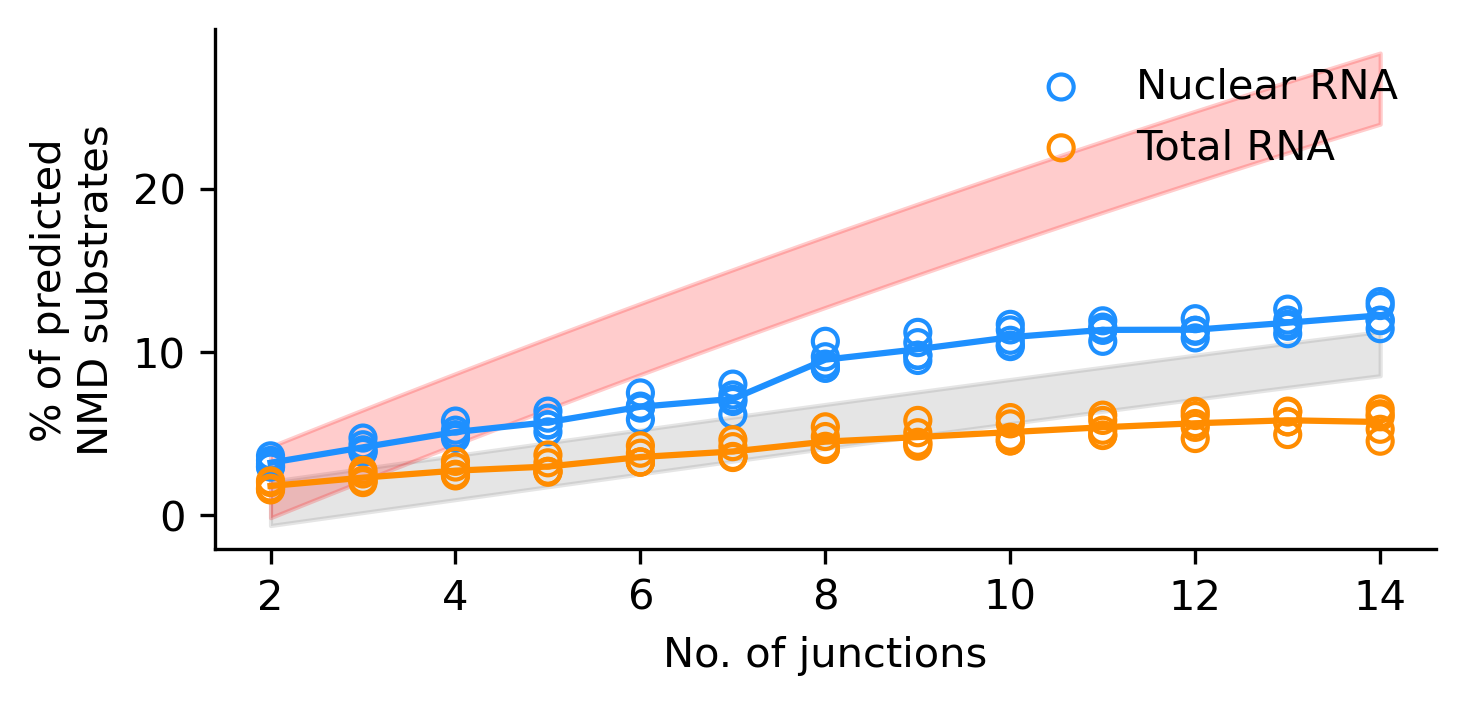

In [74]:
fig, ax = plt.subplots(figsize=(5.25, 2.25), dpi=300)

ax.fill_between(np.linspace(2, 14, num=100), pred_007.lwr*100, pred_007.upr*100, color='gray', alpha=0.2, zorder=0)

ax.fill_between(np.linspace(2, 14, num=100), pred_04.lwr*100, pred_04.upr*100, color='red', alpha=0.2, zorder=0)

for i in range(len(nuclear_NMD_reads)):
    l = nuclear_NMD_reads[i]
    if i == 0:
        ax.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   label='Nuclear RNA', )
    else:
        ax.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(nuclear_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax.plot(np.arange(1, len(l)-1)+1, mean_, c='#1e7cff')
        

    
for i in range(len(total_NMD_reads)):
    l = total_NMD_reads[i]
    if i == 0:
        ax.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                    label='Total RNA')
    else:
        ax.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(total_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax.plot(np.arange(1, len(l)-1)+1, mean_, c='darkorange')
    
ax.set_xlabel('No. of junctions')
ax.set_ylabel('% of predicted\nNMD substrates')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.legend(frameon=False)

In [2]:
y=[0.0719062311904433, 0.165340378359437, 0.26095442653579, 0.867496546847229, 0.906430243520122, 0.881338627933983]
rmats_score = [0.414,0.279,0.307,0.566,0.339,0.437]
df = pd.DataFrame()
df['model'] = ['ebpmf_brain_cortex']*3 + ['ebpmf_muscle_skeletal']*3 + ['rmats_brain_cortex']*3 + ['rmats_muscle_skeletal']*3
df['score'] = y + rmats_score

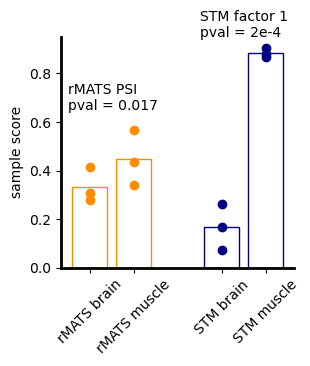

In [6]:
fig, ax = plt.subplots(figsize=(3, 3))

rmats_bc = [0.414,0.279,0.307]
rmats_ms = [0.566,0.339,0.437]
ebpmf_bc = [0.0719062311904433, 0.165340378359437, 0.26095442653579]
ebpmf_ms = [0.867496546847229, 0.906430243520122, 0.881338627933983]

            
means = [np.mean(rmats_bc), np.mean(rmats_ms), np.mean(ebpmf_bc), np.mean(ebpmf_ms)]
names = ["rMATS brain", "rMATS muscle", "STM brain", "STM muscle"]

ax.bar([1, 2], means[:2], facecolor='white',  edgecolor='darkorange')
ax.bar([4, 5], means[2:], facecolor='white',  edgecolor='navy')
plt.xticks(rotation=45)

# plt.plot([1]*len(rmats_bc), rmats_bc, 'o', color='red')

# Add dots
ax.plot([1]*len(rmats_bc), rmats_bc, 'o', color='darkorange')
ax.plot([2]*len(rmats_ms), rmats_ms, 'o', color='darkorange')
ax.plot([4]*len(ebpmf_bc), ebpmf_bc, 'o', color='navy')
ax.plot([5]*len(ebpmf_ms), ebpmf_ms, 'o', color='navy')

plt.xticks([1, 2, 4, 5], names)


ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('sample score')

ax.patch.set_facecolor('none')

ax.text(0.5, 0.65, 'rMATS PSI\npval = 0.017')
ax.text(3.5, 0.95, 'STM factor 1\npval = 2e-4')

plt.savefig('plots/rmats_v_stm.pdf', bbox_inches='tight')
# N

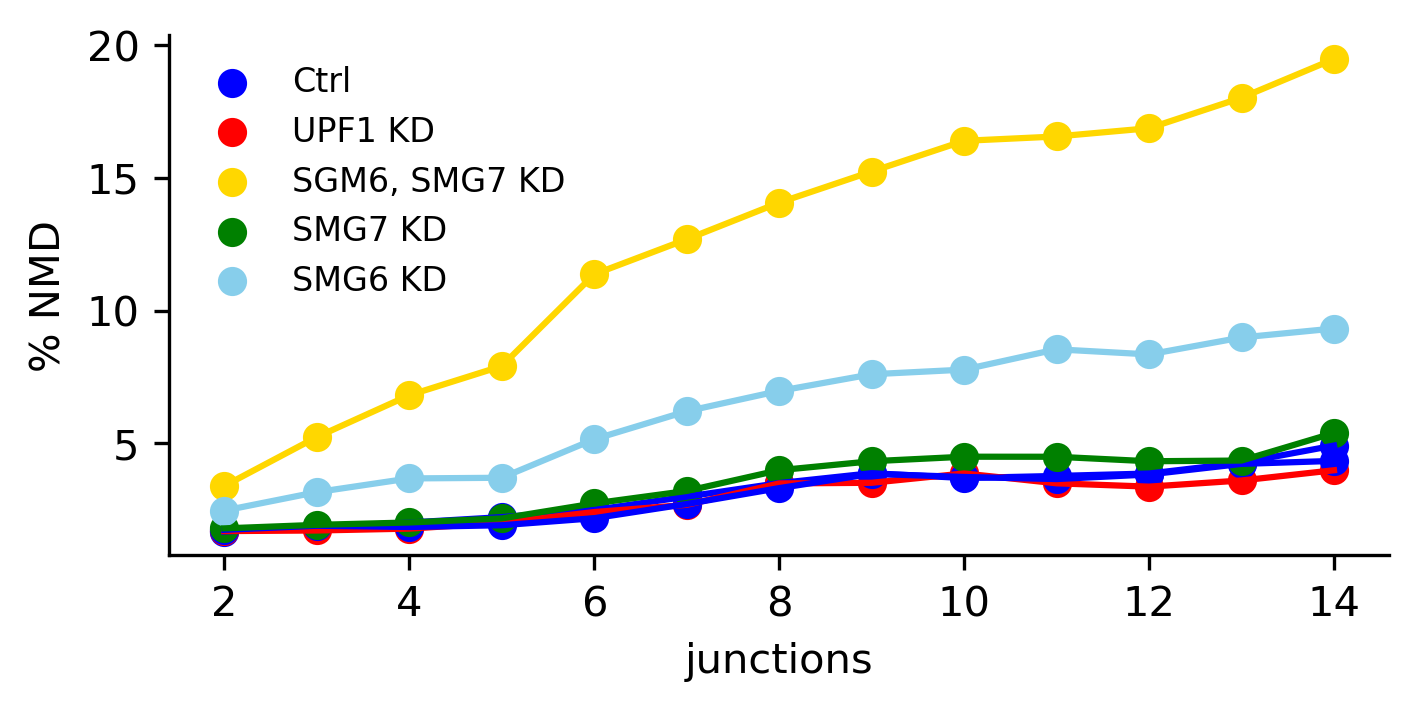

In [6]:
juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

upf1_junc, upf1_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/UPF1_shRNA.SAMEA8691115.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

ctrl1_junc, ctrl1_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/CTRL1_shRNA.SAMEA8691110.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

ctrl2_junc, ctrl2_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/CTRL2_shRNA.SAMEA8691111.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

smg_junc, smg_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/SMG6_SMG7_shRNA.SAMEA8691113.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

smg7_junc, smg7_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/SMG7_shRNA.SAMEA8691114.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

smg6_junc, smg6_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/SMG6_shRNA.SAMEA8691112.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove)

fig, ax = plt.subplots(figsize=(5.25, 2.25), dpi=300)

ax.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl1_NMD_reads[1:])*100, c='blue', label='Ctrl')
ax.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(upf1_NMD_reads[1:])*100, c='red', label='UPF1 KD')
ax.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl2_NMD_reads[1:])*100, c='blue')
ax.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(smg_NMD_reads[1:])*100, c='gold', label ='SGM6, SMG7 KD')
ax.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(smg7_NMD_reads[1:])*100, c='green', label ='SMG7 KD')
ax.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(smg6_NMD_reads[1:])*100, c='skyblue', label ='SMG6 KD')

ax.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl1_NMD_reads[1:])*100, c='blue')
ax.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(upf1_NMD_reads[1:])*100, c='red')
ax.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl2_NMD_reads[1:])*100, c='blue')
ax.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(smg_NMD_reads[1:])*100, c='gold',)
ax.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(smg7_NMD_reads[1:])*100, c='green',)
ax.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(smg6_NMD_reads[1:])*100, c='skyblue', )

plt.legend(frameon=False, fontsize=8)
ax.set_xlabel('junctions')
ax.set_ylabel('% NMD')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [7]:
juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

dmso1_junc, dmso1_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/K562_ONT_DMSO_1.SAMN11467430.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove)

dmso2_junc, dmso2_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/K562_ONT_DMSO_2.SAMN11467429.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove)



 
chRNA1_junc, chRNA1_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/K562_4sUchr_ONT_1.SAMN10505969.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove)

chRNA2_junc, chRNA2_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/K562_4sUchr_ONT_2.SAMN10505968.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove)

chRNA3_junc, chRNA3_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/K562_4sUchr_ONT_3.SAMN10505967.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove)

chRNA4_junc, chRNA4_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/K562_4sUchr_ONT_4.SAMN12726878.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove)

chRNA5_junc, chRNA5_NMD_reads = wrap_junc(
    '../code/LongReads/Junctions/K562_4sUchr_ONT_5a.SAMN12726877.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove)

ValueError: x and y must have same first dimension, but have shapes (13,) and (14,)

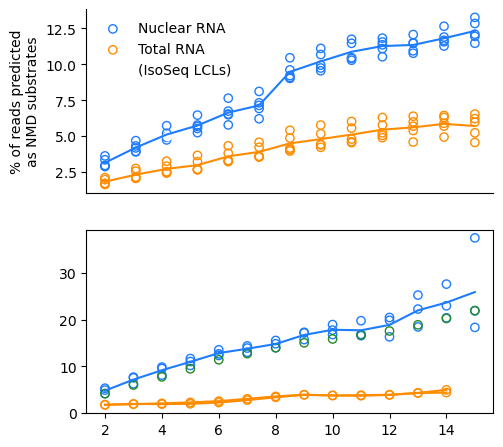

In [15]:
figsize = (5.25, 5.25)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, gridspec_kw={'hspace': 0.2})



for i in range(len(nuclear_NMD_reads)):
    l = nuclear_NMD_reads[i]
    if i == 0:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   label='Nuclear RNA', )
    else:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(nuclear_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax1.plot(np.arange(1, len(l)-1)+1, mean_, c='#1e7cff')
ax1.set_xticks([])    

    
for i in range(len(total_NMD_reads)):
    l = total_NMD_reads[i]
    if i == 0:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                    label='Total RNA')
    else:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(total_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax1.plot(np.arange(1, len(l)-1)+1, mean_, c='darkorange')
    
ax1.set_ylabel('% of reads predicted\nas NMD substrates')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.scatter([4], [5], c='white', label='(IsoSeq LCLs)')

ax1.legend(frameon=False)


ax2.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl1_NMD_reads[1:])*100, edgecolor='darkorange', 
            facecolor="None", label='Total RNA HeLa\n(Karousis et al.)')
ax2.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl2_NMD_reads[1:])*100, edgecolor='darkorange', 
            facecolor="None")
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(chRNA3_NMD_reads[1:])*100, edgecolor='#1e7cff', 
            facecolor="None", label ='K562 chRNA\n(Drexler et al.)')
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(chRNA4_NMD_reads[1:])*100, edgecolor='#1e7cff', 
            facecolor="None", )
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(chRNA5_NMD_reads[1:])*100, edgecolor='#1e7cff', 
            facecolor="None", )
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(smg_NMD_reads[1:])*100, edgecolor='forestgreen', 
            facecolor="None", label ='SGM 2KD HeLa\n(Karousis et al.)')


ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl1_NMD_reads[1:])*100, c='darkorange')
ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl2_NMD_reads[1:])*100, c='darkorange')

nmd_i = []
for i in range(len(chRNA3_NMD_reads)):
    nmd_i.append(np.mean([chRNA3_NMD_reads[i], chRNA4_NMD_reads[i], chRNA5_NMD_reads[i]]))
    
ax2.plot(range(2, len(dmso1_NMD_reads)+1), np.array(nmd_i[1:])*100, c='#1e7cff', )
ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(smg_NMD_reads[1:])*100, c='forestgreen',)

plt.legend(frameon=False, fontsize=8)
ax2.set_ylabel('% of reads predicted\nas NMD substrates')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel('No. of junctions in long read')


plt.savefig('../code/plots/Fig1.long_reads.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/plots/Fig1.long_reads.png', dpi=300, bbox_inches='tight',)

In [9]:
juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

smg_NMD_reads = subsample_juncs('../code/LongReads/Junctions/SMG6_SMG7_shRNA.SAMEA8691113.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove)



juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

dmso1_NMD_reads = subsample_juncs('../code/LongReads/Junctions/K562_ONT_DMSO_1.SAMN11467430.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove)

dmso2_NMD_reads = subsample_juncs('../code/LongReads/Junctions/K562_ONT_DMSO_2.SAMN11467429.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove)




 
chRNA1_NMD_reads = subsample_juncs('../code/LongReads/Junctions/K562_4sUchr_ONT_1.SAMN10505969.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove)


chRNA2_NMD_reads = subsample_juncs('../code/LongReads/Junctions/K562_4sUchr_ONT_2.SAMN10505968.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove)

chRNA3_NMD_reads = subsample_juncs('../code/LongReads/Junctions/K562_4sUchr_ONT_3.SAMN10505967.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove)

chRNA4_NMD_reads = subsample_juncs('../code/LongReads/Junctions/K562_4sUchr_ONT_4.SAMN12726878.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove)


chRNA5_NMD_reads = subsample_juncs('../code/LongReads/Junctions/K562_4sUchr_ONT_5a.SAMN12726877.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove)

    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552932/552932 [01:05<00:00, 8448.11it/s]


0.019157871130627273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484057/484057 [00:56<00:00, 8540.33it/s]


0.04132364576899002


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 398467/398467 [00:46<00:00, 8494.73it/s]


0.059495516567243965


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309689/309689 [00:36<00:00, 8442.72it/s]


0.07701274504422179


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240551/240551 [00:28<00:00, 8420.36it/s]


0.0943334261757382


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182255/182255 [00:21<00:00, 8491.86it/s]


0.11359907821458945


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139100/139100 [00:16<00:00, 8398.23it/s]


0.12680086268871316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106175/106175 [00:12<00:00, 8243.01it/s]


0.13956204379562043


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80853/80853 [00:09<00:00, 8365.48it/s]


0.15001298653111203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61045/61045 [00:07<00:00, 8421.94it/s]


0.15827668113686624


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44617/44617 [00:05<00:00, 8334.53it/s]


0.16699912589371765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30503/30503 [00:03<00:00, 8406.26it/s]


0.17539258433596697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19651/19651 [00:02<00:00, 8288.79it/s]


0.1885909114039998


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11296/11296 [00:01<00:00, 8210.58it/s]


0.20228399433427763


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4866/4866 [00:00<00:00, 8246.42it/s]


0.2192766132346897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37603/37603 [00:04<00:00, 8399.95it/s]


0.014068026487248357


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25433/25433 [00:02<00:00, 8518.43it/s]


0.03829670113631896


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17281/17281 [00:02<00:00, 8419.31it/s]


0.05827209073548984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12319/12319 [00:01<00:00, 8493.13it/s]


0.07224612387369105


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8814/8814 [00:01<00:00, 8393.19it/s]


0.08463807578851827


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6438/6438 [00:00<00:00, 8446.53it/s]


0.1003417210313762


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4690/4690 [00:00<00:00, 8451.60it/s]


0.10597014925373134


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3376/3376 [00:00<00:00, 8446.10it/s]


0.10574644549763033


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2445/2445 [00:00<00:00, 8380.82it/s]


0.11738241308793455


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1668/1668 [00:00<00:00, 8375.16it/s]


0.1354916067146283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1123/1123 [00:00<00:00, 8331.14it/s]


0.14514692787177205


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:00<00:00, 8400.83it/s]


0.16988416988416988


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 520/520 [00:00<00:00, 8383.22it/s]


0.19230769230769232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 8295.66it/s]


0.20735785953177258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 8013.01it/s]


0.21481481481481482


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59192/59192 [00:06<00:00, 8494.02it/s]


0.012873361265035816


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38076/38076 [00:04<00:00, 8466.13it/s]


0.03829183737787583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25007/25007 [00:02<00:00, 8495.21it/s]


0.05742392130203543


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17000/17000 [00:02<00:00, 8440.98it/s]


0.07141176470588236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11791/11791 [00:01<00:00, 8389.84it/s]


0.08031549486896786


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8264/8264 [00:00<00:00, 8400.38it/s]


0.09184414327202323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5824/5824 [00:00<00:00, 8372.83it/s]


0.10714285714285714


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4075/4075 [00:00<00:00, 8429.68it/s]


0.12098159509202454


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2837/2837 [00:00<00:00, 8396.64it/s]


0.12689460697920338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [00:00<00:00, 8346.62it/s]


0.12705530642750373


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1372/1372 [00:00<00:00, 8284.54it/s]


0.14358600583090378


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [00:00<00:00, 8337.07it/s]


0.14869466515323496


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:00<00:00, 8379.29it/s]


0.13805970149253732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 8309.78it/s]


0.18666666666666668


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 7777.97it/s]


0.18181818181818182


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7554/7554 [00:00<00:00, 8370.40it/s]


0.012576118612655547


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4966/4966 [00:00<00:00, 8332.10it/s]


0.04148207813129279


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3268/3268 [00:00<00:00, 8392.78it/s]


0.057833537331701344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2269/2269 [00:00<00:00, 8363.91it/s]


0.07712648743940062


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1595/1595 [00:00<00:00, 8381.34it/s]


0.0877742946708464


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1115/1115 [00:00<00:00, 8420.25it/s]


0.10852017937219731


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [00:00<00:00, 8472.40it/s]


0.10484927916120576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 514/514 [00:00<00:00, 8368.16it/s]


0.13229571984435798


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:00<00:00, 8359.28it/s]


0.14124293785310735


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 8278.28it/s]


0.14522821576763487


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 8195.37it/s]


0.14619883040935672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 8015.17it/s]


0.1590909090909091


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 7773.74it/s]


0.15476190476190477


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 7464.22it/s]


0.11764705882352941


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 6529.37it/s]


0.20833333333333334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3762/3762 [00:00<00:00, 8424.64it/s]


0.01594896331738437


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2632/2632 [00:00<00:00, 8419.88it/s]


0.044832826747720364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1801/1801 [00:00<00:00, 8392.28it/s]


0.06496390893947807


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 8399.23it/s]


0.09731012658227849


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:00<00:00, 8381.61it/s]


0.111358574610245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:00<00:00, 8433.09it/s]


0.13079470198675497


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [00:00<00:00, 8329.23it/s]


0.16705882352941176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:00<00:00, 8304.69it/s]


0.22039473684210525


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 8315.95it/s]


0.18421052631578946


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 8108.71it/s]


0.17647058823529413


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 8014.50it/s]


0.19642857142857142


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 7826.82it/s]


0.14814814814814814


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 7422.54it/s]


0.11538461538461539


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 6653.16it/s]


0.11538461538461539


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 5536.04it/s]


0.09090909090909091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29475/29475 [00:03<00:00, 8453.44it/s]


0.0144529262086514


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19803/19803 [00:02<00:00, 8459.71it/s]


0.04085239610160077


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13480/13480 [00:01<00:00, 8468.85it/s]


0.06216617210682492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9523/9523 [00:01<00:00, 8401.00it/s]


0.08075186390843221


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6838/6838 [00:00<00:00, 8443.28it/s]


0.10149166422930682


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4834/4834 [00:00<00:00, 8352.82it/s]


0.12287960281340504


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3411/3411 [00:00<00:00, 8324.42it/s]


0.12987393726180005


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2510/2510 [00:00<00:00, 8390.66it/s]


0.1394422310756972


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1785/1785 [00:00<00:00, 8381.95it/s]


0.1568627450980392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1247/1247 [00:00<00:00, 8360.52it/s]


0.16760224538893345


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 875/875 [00:00<00:00, 8329.15it/s]


0.168


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 565/565 [00:00<00:00, 8275.24it/s]


0.16283185840707964


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 7963.85it/s]


0.18406593406593408


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 8055.52it/s]


0.20361990950226244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 7578.65it/s]


0.21839080459770116


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40091/40091 [00:04<00:00, 8478.90it/s]


0.017210845326881344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25970/25970 [00:03<00:00, 8480.26it/s]


0.048710050057758955


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17762/17762 [00:02<00:00, 8353.02it/s]


0.07487895507262696


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12522/12522 [00:01<00:00, 8540.72it/s]


0.09495288292605016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9140/9140 [00:01<00:00, 8394.43it/s]


0.10995623632385121


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6790/6790 [00:00<00:00, 8385.74it/s]


0.1263622974963181


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5066/5066 [00:00<00:00, 8373.16it/s]


0.14330833004342677


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3822/3822 [00:00<00:00, 8443.43it/s]


0.14809000523286237


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2798/2798 [00:00<00:00, 8318.88it/s]


0.17119370979270906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2004/2004 [00:00<00:00, 8332.69it/s]


0.18912175648702595


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1388/1388 [00:00<00:00, 8402.51it/s]


0.19740634005763688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 920/920 [00:00<00:00, 8386.31it/s]


0.20434782608695654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:00<00:00, 8390.60it/s]


0.2224025974025974


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 8267.32it/s]


0.22941176470588234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 8008.27it/s]


0.18309859154929578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18653/18653 [00:02<00:00, 8476.60it/s]


0.016940974642148717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11507/11507 [00:01<00:00, 8514.59it/s]


0.05275049969583732


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7593/7593 [00:00<00:00, 8514.00it/s]


0.07651784538390623


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5255/5255 [00:00<00:00, 8403.67it/s]


0.09800190294957184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3688/3688 [00:00<00:00, 8500.12it/s]


0.1163232104121475


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2645/2645 [00:00<00:00, 8438.04it/s]


0.13497164461247638


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1909/1909 [00:00<00:00, 8426.49it/s]


0.13881613410162388


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1412/1412 [00:00<00:00, 8446.43it/s]


0.15509915014164305


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1037/1037 [00:00<00:00, 8443.01it/s]


0.1726133076181292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 722/722 [00:00<00:00, 8465.48it/s]


0.1772853185595568


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 8228.24it/s]


0.16533864541832669


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [00:00<00:00, 8310.91it/s]


0.19822485207100593


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 8054.89it/s]


0.2523364485981308


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 7810.00it/s]


0.27586206896551724


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 7444.41it/s]

0.375


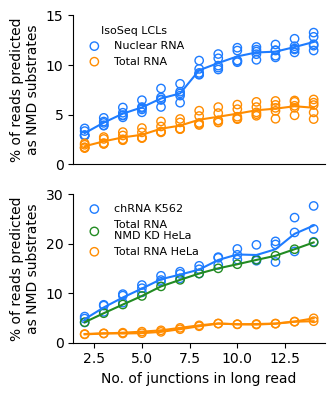

In [39]:
figsize = (3.25, 4.25)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, gridspec_kw={'hspace': 0.2})



for i in range(len(nuclear_NMD_reads)):
    l = nuclear_NMD_reads[i]
    if i == 0:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   label='Nuclear RNA', )
    else:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(nuclear_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax1.plot(np.arange(1, len(l)-1)+1, mean_, c='#1e7cff')
ax1.set_xticks([])    

    
for i in range(len(total_NMD_reads)):
    l = total_NMD_reads[i]
    if i == 0:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                    label='Total RNA')
    else:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(total_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax1.plot(np.arange(1, len(l)-1)+1, mean_, c='darkorange')
    
ax1.set_ylabel('% of reads predicted\nas NMD substrates')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# ax1.scatter([4], [5], c='white', label='(IsoSeq LCLs)')

ax1.legend(title = 'IsoSeq LCLs', frameon=False,fontsize=8, title_fontsize = 8)

# ax1.legend(frameon=False)



ax2.scatter(range(2, 15), np.array(chRNA3_NMD_reads[1:14])*100, edgecolor='#1e7cff', 
            facecolor="None", label ='chRNA K562') #\n(Drexler et al.)
ax2.scatter(range(2, 15), np.array(chRNA4_NMD_reads[1:14])*100, edgecolor='#1e7cff', 
            facecolor="None", )
ax2.scatter(range(2, 15), np.array(chRNA5_NMD_reads[1:14])*100, edgecolor='#1e7cff', 
            facecolor="None", )
ax2.scatter(range(2, 15), np.array(smg_NMD_reads[1:14])*100, edgecolor='forestgreen', 
            facecolor="None", label ='Total RNA\nNMD KD HeLa') #\n(Karousis et al.); SGM 2KD
ax2.scatter(range(2, 15), np.array(ctrl1_NMD_reads[1:14])*100, edgecolor='darkorange', 
            facecolor="None", label='Total RNA HeLa') #\n(Karousis et al.)
ax2.scatter(range(2, 15), np.array(ctrl2_NMD_reads[1:14])*100, edgecolor='darkorange', 
            facecolor="None")

ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl1_NMD_reads[1:])*100, c='darkorange')
ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl2_NMD_reads[1:])*100, c='darkorange')

nmd_i = []
for i in range(len(chRNA3_NMD_reads)):
    nmd_i.append(np.mean([chRNA3_NMD_reads[i], chRNA4_NMD_reads[i], chRNA5_NMD_reads[i]]))
    
ax2.plot(range(2, 15), np.array(nmd_i[1:14])*100, c='#1e7cff', )
ax2.plot(range(2, 15), np.array(smg_NMD_reads[1:14])*100, c='forestgreen',)

# plt.legend(frameon=False, fontsize=8)

ax2.legend(frameon=False,fontsize=8)


ax2.set_ylabel('% of reads predicted\nas NMD substrates')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel('No. of junctions in long read')

ax1.set_ylim([0, 15])

ax2.set_ylim([0, 30])


plt.savefig('../code/manuscript_plots/Fig1.long_reads.subsampled_both.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.long_reads.subsampled_both.png', dpi=300, bbox_inches='tight',)

In [19]:
len(smg_NMD_reads[1:14])

13

In [13]:
len(ctrl1_NMD_reads)

14

In [14]:
len(smg_NMD_reads)

15

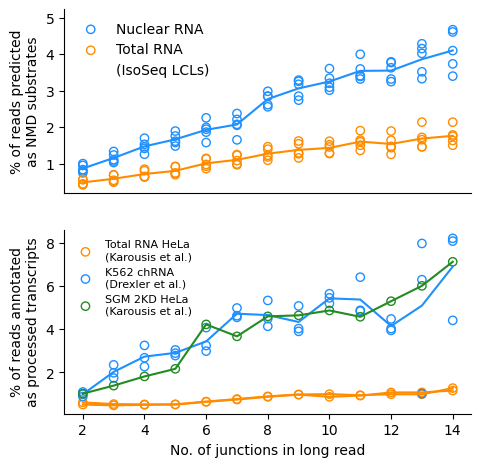

In [17]:
figsize = (5.25, 5.25)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, gridspec_kw={'hspace': 0.2})



for i in range(len(nuclear_NMD_reads)):
    l = nuclear_NMD_reads[i]
    if i == 0:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   label='Nuclear RNA', )
    else:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(nuclear_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax1.plot(np.arange(1, len(l)-1)+1, mean_, c='#1e7cff')
ax1.set_xticks([])    

    
for i in range(len(total_NMD_reads)):
    l = total_NMD_reads[i]
    if i == 0:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                    label='Total RNA')
    else:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(total_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax1.plot(np.arange(1, len(l)-1)+1, mean_, c='darkorange')
    
ax1.set_ylabel('% of reads predicted\nas NMD substrates')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.scatter([4], [5], c='white', label='(IsoSeq LCLs)')

ax1.legend(frameon=False)


ax2.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl1_NMD_reads[1:])*100, edgecolor='darkorange', 
            facecolor="None", label='Total RNA HeLa\n(Karousis et al.)')
ax2.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl2_NMD_reads[1:])*100, edgecolor='darkorange', 
            facecolor="None")
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(chRNA3_NMD_reads[1:])*100, edgecolor='#1e7cff', 
            facecolor="None", label ='K562 chRNA\n(Drexler et al.)')
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(chRNA4_NMD_reads[1:])*100, edgecolor='#1e7cff', 
            facecolor="None", )
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(chRNA5_NMD_reads[1:])*100, edgecolor='#1e7cff', 
            facecolor="None", )
ax2.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(smg_NMD_reads[1:])*100, edgecolor='forestgreen', 
            facecolor="None", label ='SGM 2KD HeLa\n(Karousis et al.)')


ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl1_NMD_reads[1:])*100, c='darkorange')
ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl2_NMD_reads[1:])*100, c='darkorange')

nmd_i = []
for i in range(len(chRNA3_NMD_reads)):
    nmd_i.append(np.mean([chRNA3_NMD_reads[i], chRNA4_NMD_reads[i], chRNA5_NMD_reads[i]]))
    
ax2.plot(range(2, len(dmso1_NMD_reads)+1), np.array(nmd_i[1:])*100, c='#1e7cff', )
ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(smg_NMD_reads[1:])*100, c='forestgreen',)

plt.legend(frameon=False, fontsize=8)
ax2.set_ylabel('% of reads annotated\nas processed transcripts')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel('No. of junctions in long read')


plt.savefig('plots/Fig1.long_reads.processed_transcript.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('plots/Fig1.long_reads.processed_transcript.png', dpi=300, bbox_inches='tight',)

In [78]:
RPKM = pd.read_csv(
    'QTLs/QTLTools/Expression.Splicing.Subset_YRI/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]

In [79]:
def get_series_quantile(series, gene_list=None, quant=4):
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list

In [84]:
Q1, Q2, Q3, Q4 = get_series_quantile(RPKM[YRI_samples].mean(axis=1))

In [85]:
Q1

Index(['ENSG00000187583.11', 'ENSG00000184163.3', 'ENSG00000162572.21',
       'ENSG00000169962.5', 'ENSG00000162576.16', 'ENSG00000235098.8',
       'ENSG00000215915.10', 'ENSG00000228594.4', 'ENSG00000189409.14',
       'ENSG00000169885.10',
       ...
       'ENSG00000184925.12', 'ENSG00000107331.17', 'ENSG00000107281.10',
       'ENSG00000176884.15', 'ENSG00000184709.7', 'ENSG00000198569.10',
       'ENSG00000197768.10', 'ENSG00000188747.8', 'ENSG00000130653.16',
       'ENSG00000148408.13'],
      dtype='object', name='pid', length=3500)

In [96]:
dmso1_junc.loc[dmso1_junc.ensembl.isin(list(Q4))]

,chrom,start,end,junction_id,read,strand,annot,ensembl,gene_id,SuperAnnotation,SemiSupergroupAnnotations,isNMD,isProteinCoding,count_exons,remove_junc,isProteinCoding_read,isNMD_read
335,chr1,944800,945042,chr1:944800-945042:-,LongRead.280,-,retained_intron.gencode,ENSG00000188976.11,NOC2L,AnnotatedJunc_UnproductiveCodingGene,uniquely retained_intron tag,True,False,1,False,True,True
336,chr1,945146,945518,chr1:945146-945518:-,LongRead.280,-,protein_coding.gencode,ENSG00000188976.11,NOC2L,AnnotatedJunc_ProductiveCodingGene,basic tag,False,True,1,False,True,True
337,chr1,945653,946173,chr1:945653-946173:-,LongRead.280,-,protein_coding.gencode,ENSG00000188976.11,NOC2L,AnnotatedJunc_ProductiveCodingGene,basic tag,False,True,1,False,True,True
338,chr1,946545,948131,chr1:946545-948131:-,LongRead.280,-,protein_coding.gencode,ENSG00000188976.11,NOC2L,AnnotatedJunc_ProductiveCodingGene,basic tag,False,True,1,False,True,True
339,chr1,948232,948490,chr1:948232-948490:-,LongRead.280,-,protein_coding.gencode,ENSG00000188976.11,NOC2L,AnnotatedJunc_ProductiveCodingGene,basic tag,False,True,1,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142474,chr22,50464738,50464819,chr22:50464738-50464819:-,LongRead.56907,-,protein_coding.gencode,ENSG00000100241.21,SBF1,AnnotatedJunc_ProductiveCodingGene,basic tag,False,True,1,False,True,False
142479,chr22,50517482,50517577,chr22:50517482-50517577:+,LongRead.56910,+,protein_coding.gencode,ENSG00000025770.19,NCAPH2,AnnotatedJunc_ProductiveCodingGene,basic tag,False,True,1,False,True,False
142480,chr22,50517661,50517741,chr22:50517661-50517741:+,LongRead.56910,+,protein_coding.gencode,ENSG00000025770.19,NCAPH2,AnnotatedJunc_ProductiveCodingGene,basic tag,False,True,1,False,True,False
142481,chr22,50517482,50517577,chr22:50517482-50517577:+,LongRead.56911,+,protein_coding.gencode,ENSG00000025770.19,NCAPH2,AnnotatedJunc_ProductiveCodingGene,basic tag,False,True,1,False,True,False


In [104]:
genes_to_subset = list(Q2) + list(Q3)
juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

upf1_junc, upf1_NMD_reads = wrap_junc(
    'LongReads/Junctions/UPF1_shRNA.SAMEA8691115.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

ctrl1_junc, ctrl1_NMD_reads = wrap_junc(
    'LongReads/Junctions/CTRL1_shRNA.SAMEA8691110.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

ctrl2_junc, ctrl2_NMD_reads = wrap_junc(
    'LongReads/Junctions/CTRL2_shRNA.SAMEA8691111.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

smg_junc, smg_NMD_reads = wrap_junc(
    'LongReads/Junctions/SMG6_SMG7_shRNA.SAMEA8691113.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

smg7_junc, smg7_NMD_reads = wrap_junc(
    'LongReads/Junctions/SMG7_shRNA.SAMEA8691114.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

smg6_junc, smg6_NMD_reads = wrap_junc(
    'LongReads/Junctions/SMG6_shRNA.SAMEA8691112.annotated.junc.gz', 
                                    juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)


juncs_to_remove = ['chr17:81510329-81510479:-','chr5:181241639-181242170:+', 'chr5:181241639-181242170:-']

dmso1_junc, dmso1_NMD_reads = wrap_junc(
    'LongReads/Junctions/K562_ONT_DMSO_1.SAMN11467430.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

dmso2_junc, dmso2_NMD_reads = wrap_junc(
    'LongReads/Junctions/K562_ONT_DMSO_2.SAMN11467429.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)



 
chRNA1_junc, chRNA1_NMD_reads = wrap_junc(
    'LongReads/Junctions/K562_4sUchr_ONT_1.SAMN10505969.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

chRNA2_junc, chRNA2_NMD_reads = wrap_junc(
    'LongReads/Junctions/K562_4sUchr_ONT_2.SAMN10505968.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

chRNA3_junc, chRNA3_NMD_reads = wrap_junc(
    'LongReads/Junctions/K562_4sUchr_ONT_3.SAMN10505967.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

chRNA4_junc, chRNA4_NMD_reads = wrap_junc(
    'LongReads/Junctions/K562_4sUchr_ONT_4.SAMN12726878.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

chRNA5_junc, chRNA5_NMD_reads = wrap_junc(
    'LongReads/Junctions/K562_4sUchr_ONT_5a.SAMN12726877.annotated.junc.gz', 
                                     juncs_to_remove = juncs_to_remove, subset_genes = genes_to_subset)

In [107]:
nmd_avgs = []
for i in range(1, 11):

    x = subsample_juncs('LongReads/Junctions/GM{i}.annotated.junc.gz'.format(i=str(i)), 
                         juncs_to_remove, subset_genes = genes_to_subset)
    nmd_avgs.append(x)
    
nuclear_NMD_reads = np.array(nmd_avgs[::2])*100
total_NMD_reads = np.array(nmd_avgs[1::2])*100

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22987/22987 [00:02<00:00, 8328.40it/s]


0.03458476530212729


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19942/19942 [00:02<00:00, 8428.72it/s]


0.07551900511483302


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17107/17107 [00:02<00:00, 8429.58it/s]


0.10130355994622084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14255/14255 [00:01<00:00, 8399.36it/s]


0.12711329358119958


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11998/11998 [00:01<00:00, 8411.98it/s]


0.13410568428071346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9874/9874 [00:01<00:00, 8278.94it/s]


0.14958476807778004


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7732/7732 [00:00<00:00, 8351.30it/s]


0.17110708742886704


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6066/6066 [00:00<00:00, 8326.74it/s]


0.1884272997032641


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 8300.23it/s]


0.19718909710391821


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3580/3580 [00:00<00:00, 8375.62it/s]


0.2058659217877095


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2593/2593 [00:00<00:00, 8336.58it/s]


0.2151947551099113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1839/1839 [00:00<00:00, 8415.77it/s]


0.21479064709081022


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1185/1185 [00:00<00:00, 8382.47it/s]


0.20928270042194091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8407.61it/s]


0.20438957475994513


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 8193.44it/s]


0.20257234726688103


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21118/21118 [00:02<00:00, 8365.19it/s]


0.02547589733876314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19539/19539 [00:02<00:00, 8391.55it/s]


0.055683504785301194


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17612/17612 [00:02<00:00, 8347.98it/s]


0.07074721780604133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15272/15272 [00:01<00:00, 8294.67it/s]


0.08027763226820325


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13363/13363 [00:01<00:00, 8397.62it/s]


0.08965052757614309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11331/11331 [00:01<00:00, 8269.57it/s]


0.09637278263171829


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9280/9280 [00:01<00:00, 8342.30it/s]


0.10484913793103448


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7533/7533 [00:00<00:00, 8282.35it/s]


0.10659763706358688


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5950/5950 [00:00<00:00, 8330.87it/s]


0.1134453781512605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4517/4517 [00:00<00:00, 8345.54it/s]


0.11888421518707107


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3284/3284 [00:00<00:00, 8369.75it/s]


0.12423873325213154


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2376/2376 [00:00<00:00, 8224.74it/s]


0.1191077441077441


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1634/1634 [00:00<00:00, 8405.73it/s]


0.1193390452876377


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [00:00<00:00, 8206.12it/s]


0.1264737406216506


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 8282.92it/s]


0.1266490765171504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17055/17055 [00:02<00:00, 8402.60it/s]


0.038991498094400466


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14885/14885 [00:01<00:00, 8250.45it/s]


0.08081961706415855


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12810/12810 [00:01<00:00, 8304.32it/s]


0.10960187353629977


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10794/10794 [00:01<00:00, 8348.24it/s]


0.13007226236798222


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9137/9137 [00:01<00:00, 8261.55it/s]


0.146875342015979


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7476/7476 [00:00<00:00, 8426.95it/s]


0.15877474585339754


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5988/5988 [00:00<00:00, 8367.00it/s]


0.17251169004676017


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4816/4816 [00:00<00:00, 8428.01it/s]


0.1821013289036545


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [00:00<00:00, 8364.60it/s]


0.19627882599580712


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2892/2892 [00:00<00:00, 8274.86it/s]


0.19813278008298754


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2088/2088 [00:00<00:00, 8343.75it/s]


0.2078544061302682


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:00<00:00, 8405.77it/s]


0.21964167219641673


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:00<00:00, 8336.66it/s]


0.2335907335907336


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 628/628 [00:00<00:00, 8343.28it/s]


0.24044585987261147


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 8250.21it/s]


0.24081632653061225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20611/20611 [00:02<00:00, 8338.09it/s]


0.026345155499490562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19131/19131 [00:02<00:00, 8409.27it/s]


0.05347342010349694


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17365/17365 [00:02<00:00, 8322.47it/s]


0.0697955657932623


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15176/15176 [00:01<00:00, 8365.98it/s]


0.08025830258302583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13361/13361 [00:01<00:00, 8441.10it/s]


0.08427512910710276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11391/11391 [00:01<00:00, 8324.72it/s]


0.0912123606355895


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9435/9435 [00:01<00:00, 8387.77it/s]


0.10238473767885532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7624/7624 [00:00<00:00, 8382.29it/s]


0.10886673662119623


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6032/6032 [00:00<00:00, 8316.38it/s]


0.10742705570291777


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4609/4609 [00:00<00:00, 8379.64it/s]


0.11238880451290953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3307/3307 [00:00<00:00, 8406.81it/s]


0.12095554883580284


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2422/2422 [00:00<00:00, 8384.71it/s]


0.12180016515276632


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [00:00<00:00, 8255.19it/s]


0.11440426793123888


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 8355.45it/s]


0.115234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 371/371 [00:00<00:00, 8266.11it/s]


0.13746630727762804


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17475/17475 [00:02<00:00, 8427.74it/s]


0.03347639484978541


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15313/15313 [00:01<00:00, 8479.97it/s]


0.06974466139881147


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13296/13296 [00:01<00:00, 8511.37it/s]


0.09333634175691938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11302/11302 [00:01<00:00, 8503.23it/s]


0.1155547690674217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9734/9734 [00:01<00:00, 8476.46it/s]


0.12821039654818164


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8210/8210 [00:00<00:00, 8509.50it/s]


0.15018270401948844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6616/6616 [00:00<00:00, 8472.36it/s]


0.1617291414752116


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5323/5323 [00:00<00:00, 8522.32it/s]


0.18410670674431712


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4233/4233 [00:00<00:00, 8525.85it/s]


0.19725962674226316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3297/3297 [00:00<00:00, 8506.88it/s]


0.20746132848043677


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2441/2441 [00:00<00:00, 8348.74it/s]


0.21671446128635805


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1694/1694 [00:00<00:00, 8533.37it/s]


0.21369539551357733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1142/1142 [00:00<00:00, 8333.05it/s]


0.2276707530647986


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 673/673 [00:00<00:00, 8399.44it/s]


0.2288261515601783


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 8324.28it/s]


0.25249169435215946


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23182/23182 [00:02<00:00, 8393.19it/s]


0.021956690535760503


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21732/21732 [00:02<00:00, 8407.69it/s]


0.04320817228050801


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19862/19862 [00:02<00:00, 8449.45it/s]


0.05558352633168865


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17340/17340 [00:02<00:00, 8506.62it/s]


0.06274509803921569


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15312/15312 [00:01<00:00, 8463.42it/s]


0.06805120167189133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13009/13009 [00:01<00:00, 8468.93it/s]


0.07533246214159428


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10859/10859 [00:01<00:00, 8452.03it/s]


0.0858274242563772


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8888/8888 [00:01<00:00, 8472.23it/s]


0.0952970297029703


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7149/7149 [00:00<00:00, 8355.92it/s]


0.0990348300461603


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5475/5475 [00:00<00:00, 8407.30it/s]


0.10392694063926941


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3979/3979 [00:00<00:00, 8433.37it/s]


0.11761749183211863


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:00<00:00, 8428.36it/s]


0.09190526687875575


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1938/1938 [00:00<00:00, 8388.95it/s]


0.0933952528379773


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:00<00:00, 8302.55it/s]


0.09009812667261374


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [00:00<00:00, 8306.19it/s]


0.10218978102189781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18797/18797 [00:02<00:00, 8477.94it/s]


0.035909985636005747


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16701/16701 [00:01<00:00, 8508.38it/s]


0.07185198491108317


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14640/14640 [00:01<00:00, 8476.89it/s]


0.09911202185792349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12561/12561 [00:01<00:00, 8383.41it/s]


0.1120133747313112


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10797/10797 [00:01<00:00, 8390.07it/s]


0.12429378531073447


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9066/9066 [00:01<00:00, 8532.13it/s]


0.14273108316788


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7312/7312 [00:00<00:00, 8433.94it/s]


0.162472647702407


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5896/5896 [00:00<00:00, 8346.90it/s]


0.17808683853459972


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4637/4637 [00:00<00:00, 8450.74it/s]


0.1938753504420962


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3644/3644 [00:00<00:00, 8432.83it/s]


0.1951152579582876


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2708/2708 [00:00<00:00, 8396.89it/s]


0.20827178729689808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1956/1956 [00:00<00:00, 8423.32it/s]


0.21625766871165644


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1333/1333 [00:00<00:00, 8302.37it/s]


0.21530382595648911


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 797/797 [00:00<00:00, 8466.58it/s]


0.22710163111668757


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 8351.64it/s]


0.23466666666666666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21893/21893 [00:02<00:00, 8516.53it/s]


0.021605079249075048


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20447/20447 [00:02<00:00, 8400.33it/s]


0.04665721132684501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18563/18563 [00:02<00:00, 8437.50it/s]


0.05796476862576092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16075/16075 [00:01<00:00, 8380.63it/s]


0.06793157076205288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14170/14170 [00:01<00:00, 8412.14it/s]


0.07360621030345801


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12061/12061 [00:01<00:00, 8440.26it/s]


0.08258021722908548


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9977/9977 [00:01<00:00, 8395.42it/s]


0.09161070462062744


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8086/8086 [00:00<00:00, 8449.25it/s]


0.0954736581746228


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6415/6415 [00:00<00:00, 8384.99it/s]


0.10350740452065471


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4876/4876 [00:00<00:00, 8446.80it/s]


0.10315832649712879


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3544/3544 [00:00<00:00, 8404.35it/s]


0.10976297968397292


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2595/2595 [00:00<00:00, 8330.70it/s]


0.11329479768786127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1754/1754 [00:00<00:00, 8337.12it/s]


0.1225769669327252


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 8312.56it/s]


0.11210317460317461


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 8245.77it/s]


0.14698162729658792


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16881/16881 [00:02<00:00, 8412.72it/s]


0.03269948462768793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14864/14864 [00:01<00:00, 8517.61it/s]


0.06646932185145317


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12836/12836 [00:01<00:00, 8459.23it/s]


0.09239638516671861


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10967/10967 [00:01<00:00, 8501.91it/s]


0.11087808881189022


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9401/9401 [00:01<00:00, 8514.43it/s]


0.12275289862780556


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7950/7950 [00:00<00:00, 8419.92it/s]


0.13685534591194967


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6395/6395 [00:00<00:00, 8435.14it/s]


0.1532447224394058


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5074/5074 [00:00<00:00, 8388.36it/s]


0.16653527788726843


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:00<00:00, 8392.49it/s]


0.17704081632653063


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2987/2987 [00:00<00:00, 8513.12it/s]


0.19618346166722464


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:00<00:00, 8420.33it/s]


0.2222222222222222


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1548/1548 [00:00<00:00, 8498.24it/s]


0.21705426356589147


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1064/1064 [00:00<00:00, 8323.44it/s]


0.22180451127819548


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 593/593 [00:00<00:00, 8274.94it/s]


0.21247892074198987


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 8108.57it/s]


0.19148936170212766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19563/19563 [00:02<00:00, 8496.96it/s]


0.022031385779277206


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18300/18300 [00:02<00:00, 8490.69it/s]


0.04300546448087432


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16641/16641 [00:01<00:00, 8468.39it/s]


0.056246619794483504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14542/14542 [00:01<00:00, 8403.05it/s]


0.0676660706917893


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12889/12889 [00:01<00:00, 8443.69it/s]


0.0724648925440298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11023/11023 [00:01<00:00, 8390.15it/s]


0.07838156581692825


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9097/9097 [00:01<00:00, 8476.65it/s]


0.0900296801143234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7491/7491 [00:00<00:00, 8436.13it/s]


0.09651581898277933


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5932/5932 [00:00<00:00, 8300.63it/s]


0.09895482130815914


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4610/4610 [00:00<00:00, 8371.19it/s]


0.10260303687635575


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3316/3316 [00:00<00:00, 8478.61it/s]


0.11731001206272618


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2418/2418 [00:00<00:00, 8278.84it/s]


0.11993382961124896


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1695/1695 [00:00<00:00, 8286.74it/s]


0.12271386430678466


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 8333.86it/s]


0.12996031746031747


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 8279.59it/s]

0.13110539845758354


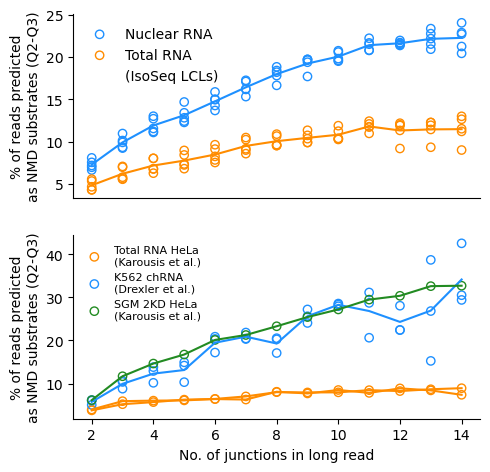

In [109]:
figsize = (5.25, 5.25)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, gridspec_kw={'hspace': 0.2})



for i in range(len(nuclear_NMD_reads)):
    l = nuclear_NMD_reads[i]
    if i == 0:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   label='Nuclear RNA', )
    else:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='#1e7cff', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(nuclear_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax1.plot(np.arange(1, len(l)-1)+1, mean_, c='#1e7cff')
ax1.set_xticks([])    

    
for i in range(len(total_NMD_reads)):
    l = total_NMD_reads[i]
    if i == 0:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                    label='Total RNA')
    else:
        ax1.scatter(np.arange(1, len(l)-1)+1, l[1:-1], edgecolor='darkorange', facecolor="None",
                   )
        
mean_ = [np.mean((np.array(total_NMD_reads).T)[i]) for i in range(1, len(l)-1)]
ax1.plot(np.arange(1, len(l)-1)+1, mean_, c='darkorange')
    
ax1.set_ylabel('% of reads predicted\nas NMD substrates (Q2-Q3)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.scatter([4], [5], c='white', label='(IsoSeq LCLs)')

ax1.legend(frameon=False)


ax2.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl1_NMD_reads[1:])*100, edgecolor='darkorange', 
            facecolor="None", label='Total RNA HeLa\n(Karousis et al.)')
ax2.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl2_NMD_reads[1:])*100, edgecolor='darkorange', 
            facecolor="None")
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(chRNA3_NMD_reads[1:])*100, edgecolor='#1e7cff', 
            facecolor="None", label ='K562 chRNA\n(Drexler et al.)')
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(chRNA4_NMD_reads[1:])*100, edgecolor='#1e7cff', 
            facecolor="None", )
ax2.scatter(range(2, len(dmso1_NMD_reads)+1), np.array(chRNA5_NMD_reads[1:])*100, edgecolor='#1e7cff', 
            facecolor="None", )
ax2.scatter(range(2, len(ctrl1_NMD_reads)+1), np.array(smg_NMD_reads[1:])*100, edgecolor='forestgreen', 
            facecolor="None", label ='SGM 2KD HeLa\n(Karousis et al.)')


ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl1_NMD_reads[1:])*100, c='darkorange')
ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(ctrl2_NMD_reads[1:])*100, c='darkorange')

nmd_i = []
for i in range(len(chRNA3_NMD_reads)):
    nmd_i.append(np.mean([chRNA3_NMD_reads[i], chRNA4_NMD_reads[i], chRNA5_NMD_reads[i]]))
    
ax2.plot(range(2, len(dmso1_NMD_reads)+1), np.array(nmd_i[1:])*100, c='#1e7cff', )
ax2.plot(range(2, len(ctrl1_NMD_reads)+1), np.array(smg_NMD_reads[1:])*100, c='forestgreen',)

plt.legend(frameon=False, fontsize=8)
ax2.set_ylabel('% of reads predicted\nas NMD substrates (Q2-Q3)')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel('No. of junctions in long read')


plt.savefig('plots/Fig1.long_reads_Q2_and_Q3.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('plots/Fig1.long_reads_Q2_and_Q3.png', dpi=300, bbox_inches='tight',)

In [18]:
n_junc, n_NMD_reads, = wrap_junc('LongReads/Junctions/GM1.annotated.junc.gz'.format(i=str(i)), 
                                    juncs_to_remove = juncs_to_remove)

In [25]:
n_junc.loc[n_junc.SuperAnnotation.isin(
    ['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
)].shape[0]

20895

In [26]:
n_junc.shape[0]

700120

In [27]:
20895/700120

0.029844883734216992

In [34]:
n_junc.loc[n_junc.SuperAnnotation.isin(
    ['AnnotatedJunc_UnproductiveCodingGene']
) & (n_junc.SemiSupergroupAnnotations == 'uniquely processed_transcript tag')].shape[0]

11610

In [28]:
n_junc.loc[n_junc.SuperAnnotation.isin(
    ['AnnotatedJunc_UnproductiveCodingGene']
)].shape[0]

15489

In [30]:
n_junc.loc[n_junc.SuperAnnotation.isin(
    ['AnnotatedJunc_UnproductiveCodingGene', 'AnnotatedJunc_ProductiveCodingGene', 'AnnotatedJunc_NoncodingGene']
)].shape[0]

692954

In [35]:
11610/692954

0.016754358875192294

In [33]:
n_junc.SemiSupergroupAnnotations.unique()

array(['uniquely psueodgene tag', 'overlaps pseudogene',
       'uniquely lncRNA tag', 'uniquely processed_transcript tag',
       'overlaps processed transcript intron', 'basic tag',
       'uniquely retained_intron tag', 'frame preserving skipped exon',
       'predicted_NMD YN', 'predicted_NMD pstopcodon', 'overlaps lncRNA',
       'uniquely nonsense_mediated_decay tag', 'predicted_NMD far5p',
       'predicted_NMD UTRjunction', 'predicted_NMD far3p',
       'predicted_NMD reason2', 'stable.NY',
       'overlaps nonsense_mediated_decay intron',
       'uniquely non_stop_decay tag', 'hypervariable genes tag',
       'overlaps retained_intron tag', 'overlaps hypervariable gene'],
      dtype=object)